In [1]:
from pnets.plotting import interval_graph
from bokeh.plotting import figure, show, output_notebook
output_notebook()

Loading BokehJS ...

# MTL Hardware description

### MTL Composed of:
#####    - 2 Atoms quad
#####    - 2 Big cores
#####    - 1 GT
#####    - LLC & DDR memories
#####    - They are connected to Bus (1 port for quad)

In [2]:
# Platform modules
from asap.system_platform import Platform
from asap.hw import Clock, GlobalClock
from asap.ips import IP, Driver, ExecutingUnit, Port
from asap.buses import Bus
from asap.memories import Memory
from asap.strings import PENALTY

Validating System platform: MTL...
System platform is valid!


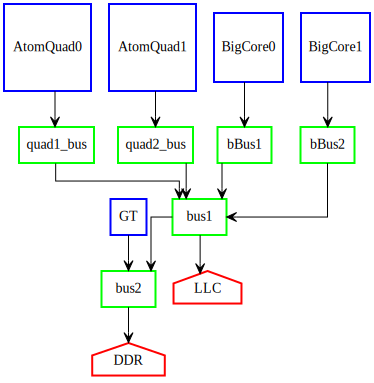

In [3]:

PENALTY_VAL = 1.13333

# Platform
sys_platform = Platform("MTL")

# Clocks
clk = GlobalClock("global_clk", 0.01).instance
a_clk = Clock("a_clk", 0.01)    # 10 ns
b_clk = Clock("b_clk", 0.01)    # 10 ns
g_clk = Clock("g_clk", 0.01)    # 10 ns
sys_platform.add_clocks([clk, a_clk, b_clk, g_clk])

# IPs:
# - Ports
# - Drivers
# - Executing units

# Atoms
atoms = dict()
for atom_name in ["AtomQuad{}".format(i) for i in range(2)]:
    p = Port(atom_name + "_p")
    dr = Driver("driver", a_clk)
    ex_units = list()
    for ex in ["ex_u{}".format(j) for j in range(4)]:
        ex_units.append(ExecutingUnit(ex, a_clk))

    atom = IP(atom_name, a_clk, ex_units, [dr], [p])
    atom.connect_driver(dr, p)
    atom.attach_attribute(PENALTY, PENALTY_VAL)
    sys_platform.add_ip(atom)
    atoms[atom_name] = (atom, p)
    
# Big cores
bCores = dict()
for i in range(2):
    bCoreP = Port("BigCore{}_p".format(i))
    dr = Driver("driver", b_clk)
    ex_u = ExecutingUnit("ex_u", b_clk, 1)

    bCore = IP("BigCore{}".format(i), b_clk, [ex_u], [dr], [bCoreP])
    bCore.connect_driver(dr, bCoreP)
    bCore.attach_attribute(PENALTY, 1)
    sys_platform.add_ip(bCore)
    bCores[bCore.name] = (bCore, bCoreP)

# GT 
gt_p = Port('p')
gt_dr = Driver('dr', g_clk)
gt_ex = ExecutingUnit('ex_u', g_clk)

gt = IP("GT", g_clk, [gt_ex], [gt_dr], [gt_p])
gt.connect_driver(gt_dr, gt_p)
sys_platform.add_ip(gt)

# IP Buses
quad1_bus = Bus('quad1_bus', clk, 64)
quad2_bus = Bus('quad2_bus', clk, 64)
bBus1 = Bus('bBus1', clk, 64)
bBus2 = Bus('bBus2', clk, 64)
sys_platform.add_bus(quad1_bus)
sys_platform.add_bus(quad2_bus)
sys_platform.add_bus(bBus1)
sys_platform.add_bus(bBus2)

# System buses
bus1 = Bus('bus1', clk, 64)
bus2 = Bus('bus2', clk, 64)
sys_platform.add_bus(bus1)
sys_platform.add_bus(bus2)

# Memories
llc = Memory('LLC', clk, 1024)
ddr = Memory('DDR', clk, 1024)
sys_platform.add_memory(llc)
sys_platform.add_memory(ddr)

# Connecting
sys_platform.connect_to_bus(atoms["AtomQuad0"][1], quad1_bus)
sys_platform.connect_to_bus(atoms["AtomQuad1"][1], quad2_bus)

sys_platform.connect_to_bus(bCores["BigCore0"][1], bBus1)
sys_platform.connect_to_bus(bCores["BigCore1"][1], bBus2)

sys_platform.connect_to_bus(bBus1, bus1)
sys_platform.connect_to_bus(bBus2, bus1)
sys_platform.connect_to_bus(quad1_bus, bus1)
sys_platform.connect_to_bus(quad2_bus, bus1)
sys_platform.connect_to_bus(bus1, bus2)

sys_platform.connect_to_memory(bus1, llc)
sys_platform.connect_to_memory(bus2, ddr)
sys_platform.connect_to_bus(gt_p, bus2)

sys_platform.validate_platform()
sys_platform

# Atom first scheduler
#### Preferes to map task of map type "Core" to atoms first, if no atom is available then map to big cores
#### Tasks mapped to atom has extra penalty

In [4]:
from asap.schedulers import SystemScheduler
from asap.mapping import MappingEntity
from asap.strings import SchedulingState
from collections import namedtuple

class AtomFirstScheduler(SystemScheduler):
    """
    Atom first scheduler:
        prefer tasks that should be mapped to resource of type core to atoms first with penalty, if all atoms are busy then map to CPU
    """
    def __init__(self,  system_mgr, properties=None, platform_scheduler=None):
        super().__init__(system_mgr, properties, platform_scheduler)
        self._atoms = self._get_ips(['AtomQuad0', 'AtomQuad1'])
        self._bCores = self._get_ips(['BigCore0', 'BigCore1'])
        self._gt = self._get_ips(['GT'])[0]
        
    def _get_ips(self, names):
        ips = list()
        for ip in self._system_mgr.sys_platform.ips:
            if ip.name in names:
                ips.append(ip)
        return ips
    
    def schedule_task(self, task, resource):
        task_map_type = task.get_attribute('MAP_TYPE', None)
        if task_map_type is None:
            return self._platform_scheduler.schedule_task(task, list())
        elif task_map_type == 'GT':
            return self._platform_scheduler.schedule_task(task, [MappingEntity(task, self._gt)])
        elif task_map_type == 'Core':
            r, t = self._platform_scheduler.schedule_task(task, [MappingEntity(task, a) for a in self._atoms])
            if r is not None or t != SchedulingState.NAN:
                return r, t
            return self._platform_scheduler.schedule_task(task, [MappingEntity(task, b) for b in self._bCores])
        else:
            return self._platform_scheduler.schedule_task(task, list())
    
    def on_task_finish(self, task):
        self._platform_scheduler.on_task_finish(task)


# Abstart workload
### 2 levels of parallel tasks

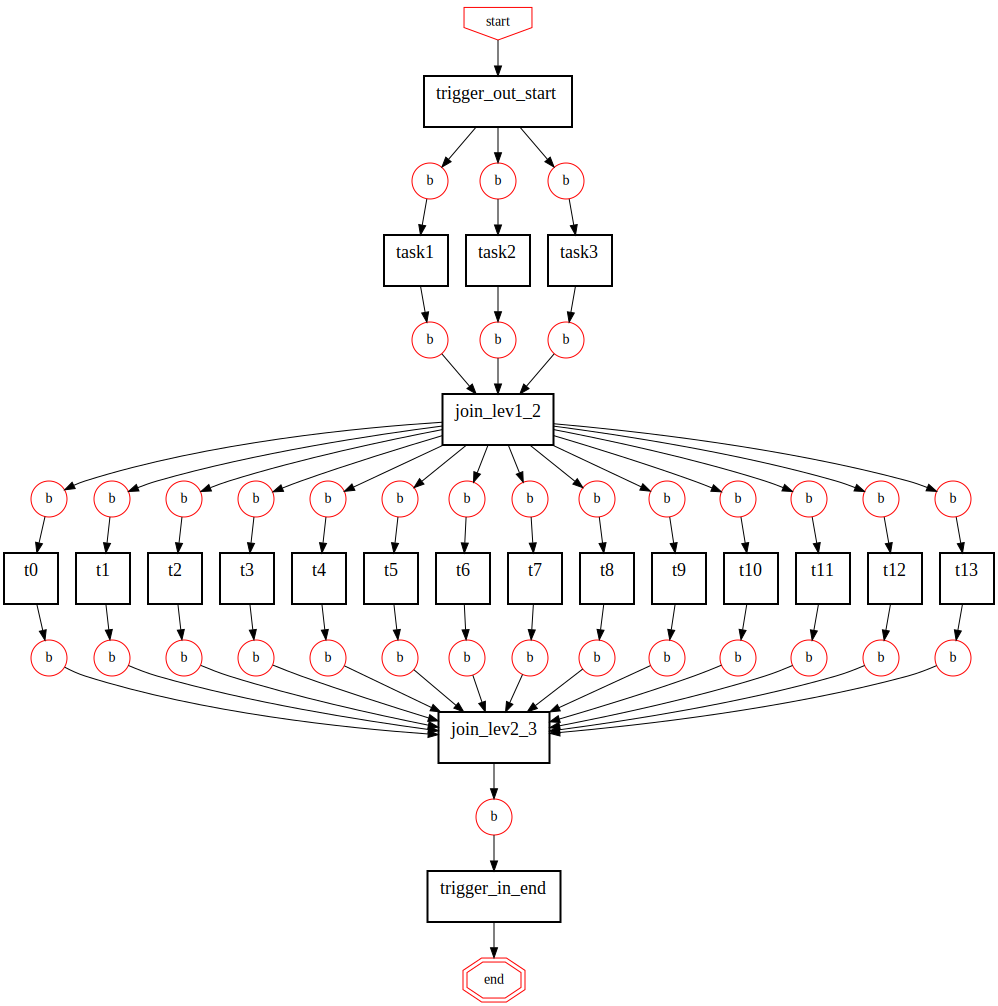

In [5]:
from asap.workload import Workload, Task, Connection, TYPES
from asap.mapping import Mapping
from asap.strings import MappingDesc

wl = Workload('abstract')
m = Mapping('mapping', wl)

start = Task('start', TYPES.START)
wl.add_task(start)

# Level 1
# Building workload Step by step
j1 = Task('join_lev1_2')
wl.add_task(j1)
t = Task('task1', type=TYPES.READ, read_bytes=10240)
t.attach_attribute(MappingDesc.MEMORY_TARGET, 'LLC')
t.attach_attribute('MAP_TYPE', 'Core')
wl.add_task(t)
wl.connect_tasks('1', t, j1)
wl.connect_tasks('2', start, t)
t = Task('task2', type=TYPES.WRITE, write_bytes=20480)
t.attach_attribute(MappingDesc.MEMORY_TARGET, 'LLC')
t.attach_attribute('MAP_TYPE', 'Core')
wl.add_task(t)
wl.connect_tasks('3', t, j1)
wl.connect_tasks('4', start, t)
t = Task('task3', type=TYPES.PROC, processing_cycles=3000)
t.attach_attribute(MappingDesc.MEMORY_TARGET, 'LLC')
t.attach_attribute('MAP_TYPE', 'GT')
wl.add_task(t)
wl.connect_tasks('5', t, j1)
wl.connect_tasks('6', start, t)

j2 = Task('join_lev2_3')
wl.add_task(j2)


# Level 2
# Building workload using python capabilities
# All second level is mapped to Atom
for i in range(14):
    t = Task('t{}'.format(i), type=TYPES.PROC, processing_cycles=3540)
    t.attach_attribute('MAP_TYPE', 'Core')
    wl.add_task(t)
    wl.connect_tasks('con{}'.format(i), j1, t)
    wl.connect_tasks('con_{}'.format(i), t, j2)
        
end = Task('end', type=TYPES.END)
wl.add_task(end)
wl.connect_tasks('7', j2, end)
wl

# Running simulation with:
#### - AtomFirstScheduler
#### - Abstarc fabric

In [6]:
from asap.strings import TaskMetaData
from asap.utils import from_pnml_model
from speedsim import SpeedSim
from models.fabric.abstract_fabric import FabricExtension 

# Clock
a_clk.period = 0.0005 # 
b_clk.period = 0.00025
g_clk.period = 0.001 # 

sys_platform.reset()
speedsim = SpeedSim(sys_platform, wl, m)
speedsim.set_system_scheduler(AtomFirstScheduler)
speedsim.add_extension('FabricExtension', FabricExtension)
res = speedsim.simulate(1000000)

## Simulation results - task analysis table

In [7]:
res

,START,FINISH,TRANSITION,RESOURCE,RESOURCE_IDX,DURATION
0,0.000,3.000000,task3,GT/ex_u,0,3.000000
1,0.000,3.200000,task1,AtomQuad0/driver,0,3.200000
2,0.000,4.800000,task2,AtomQuad1/driver,0,4.800000
3,4.800,4.800000,join_lev1_2,NULL,0,0.000000
4,4.800,5.685000,t8,BigCore0/ex_u,0,0.885000
5,4.800,5.685000,t9,BigCore1/ex_u,0,0.885000
8,4.800,6.805994,t0,AtomQuad0/ex_u0,0,2.005994
9,4.800,6.805994,t1,AtomQuad0/ex_u1,0,2.005994
10,4.800,6.805994,t2,AtomQuad0/ex_u2,0,2.005994
11,4.800,6.805994,t3,AtomQuad0/ex_u3,0,2.005994


## task analysis graph

In [16]:
from post_processing.graphs import create_task_analysis_fig
from bokeh.plotting import output_notebook, show

fig = create_task_analysis_fig(res)
show(fig)

# HW Runtime and Residency table
#### Start and end times for every resource
##### Note: If end time is not specified, it set to be the end of the simulation

In [9]:
from asap.strings import ResourceDesc
from post_processing.utils import get_hw_analysis

# We can set start, end and interval
# IP runtime table (other options: bus/memory)

runtime_ip, interval_ip = get_hw_analysis(ResourceDesc.IP, intervals=3) 
runtime_ip

,START,FINISH,RESOURCE,DURATION
0,0.000,3.000000,GT/ex_u,3.000000
1,0.000,3.200000,AtomQuad0/driver,3.200000
2,0.000,4.800000,AtomQuad1/driver,4.800000
3,4.800,5.685000,BigCore0/ex_u,0.885000
4,4.800,5.685000,BigCore1/ex_u,0.885000
5,5.685,6.570000,BigCore0/ex_u,0.885000
6,5.685,6.570000,BigCore1/ex_u,0.885000
7,4.800,6.805994,AtomQuad0/ex_u0,2.005994
8,4.800,6.805994,AtomQuad0/ex_u1,2.005994
9,4.800,6.805994,AtomQuad0/ex_u2,2.005994


#### Interval residency table
#### Residency table for specific resource per interval 

In [10]:
interval_ip

,0.00-2.48,2.48-4.97,4.97-7.46
GT/ex_u,100.0,20.724346,0.000000
AtomQuad0/driver,100.0,28.772636,0.000000
AtomQuad1/driver,100.0,93.158954,0.000000
BigCore0/ex_u,0.0,6.841046,100.000000
BigCore1/ex_u,0.0,6.841046,100.000000
AtomQuad0/ex_u0,0.0,6.841046,73.883062
AtomQuad0/ex_u1,0.0,6.841046,73.883062
AtomQuad0/ex_u2,0.0,6.841046,73.883062
AtomQuad0/ex_u3,0.0,6.841046,73.883062
AtomQuad1/ex_u0,0.0,6.841046,73.883062


## Bandwith table (output from fabric extension - custom analysis!)
##### in our case:
##### - BW data on ip - minimum bw ip see in his way to memory
##### - BW data on bus

In [11]:
extension = speedsim.get_extension('FabricExtension')
bus_bw_table, driver_bw_table = extension.get_bw_intervals()

# Ip bw table
driver_bw_table

,START,FINISH,RESOURCE,TARGET,BW
0,0.0,0.0,AtomQuad0/driver,LLC,6400.0
1,0.0,3.2,AtomQuad0/driver,LLC,3200.0
2,0.0,3.2,AtomQuad1/driver,LLC,3200.0
3,3.2,4.8,AtomQuad1/driver,LLC,6400.0


In [12]:
# Bus bw table
bus_bw_table

,START,FINISH,BUS,SOURCE,BW
0,0.0,7.455,quad1_bus,AtomQuad0,6400.0
1,0.0,7.455,bus1,quad1_bus,6400.0
2,0.0,7.455,quad2_bus,AtomQuad1,6400.0
3,0.0,7.455,bus1,quad2_bus,6400.0


## Concurrency table 
#### Setting expressions to get concurrency table

In [17]:
from post_processing.tables import get_concurrency_table
from asap.strings import AND, OR

# Expression consists of {'AND'/'OR': [{'title': 'value'}]}
# For example to build the following expression: (atomquad1: c0 and atomquad0: c0) or bigcore0: c0
# The dictionary should be as follows: {OR: [{AND: [{'RESOURCE': 'AtomQuad0', 'STATE': 'C0'}, {'RESOURCE': 'AtomQuad1', 'STATE': 'C0'}]}, {'RESOURCE': 'BigCore0', 'STATE': 'C0'}}
# start and end to control time range

quad0quad13200 = {AND: [{'RESOURCE': 'AtomQuad0/driver', 'BW': 3200}, {'RESOURCE': 'AtomQuad1/driver', 'BW': 3200}]}

quad0quad13200_table = get_concurrency_table(driver_bw_table, expression=quad0quad13200, expression_name='Quad1 and Quad2 3200 bw')

quad0quad13200_table

,START,FINISH,EXPRESSION
0,0.0,3.2,Quad1 and Quad2 3200 bw


## Dumping results into html report or excel file
##### option to upload results to conduit

In [15]:
from post_processing.utils import analysis_to_html, analysis_to_excel, upload_results_file

analysis_to_html('/tmp/report.html', start=0, intervals=2)

# uploading to conduit
# upload_results_file('/tmp/report.html')

## What if analysis - Atom and Big core clock frequencies

In [ ]:
from collections import namedtuple
from pandas import DataFrame

# Frequencies are in MHz
a_clk_frequencies = [800, 1000, 1200]
b_clk_frequencies = [1500, 1750, 2000]

RUN_EVENT = namedtuple('RUN_EVENT', ('ATOM_FREQUENCY', 'BIG_CORE_FREQUENCY', 'SIMULATION_TIME'))
analysis_list = list()
for atom_freq in a_clk_frequencies:
    for big_freq in b_clk_frequencies:
        a_clk.period = 1.0/atom_freq
        b_clk.period = 1.0/big_freq
        speedsim = SpeedSim(sys_platform, wl, m)
        speedsim.set_system_scheduler(AtomFirstScheduler)
        speedsim.add_extension('FabricExtension', FabricExtension)
        res = speedsim.simulate()
        analysis_list.append(RUN_EVENT(ATOM_FREQUENCY=atom_freq, BIG_CORE_FREQUENCY=big_freq,SIMULATION_TIME=speedsim.get_sim_time()))

analysis_df = DataFrame(analysis_list)
analysis_df